In [49]:
# ---------------------------------------------
# AROPHET: Hybrid Forecasting + ROP Calculation
# Combining Prophet + ARIMA for Pharma Sales
# ---------------------------------------------

# --- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [50]:
# --- Load Sales Data ---
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"
sales_data = pd.read_excel(file_path)

# --- Preview Raw Data ---
sales_data.head()

,ds,y,marketing_spend,doctor_visits,disease_trend,stock_level,lead_time_days,safety_stock,shelf_life_months,MOQ
0,2014-01-01,1187.000000,892,5048,346,6889,14,500,36,3000
1,2014-02-01,1332.860756,1555,4613,395,6701,7,1000,12,3000
2,2014-03-01,1342.644005,1301,5012,230,6291,14,1000,12,2000
3,2014-04-01,1407.575042,1755,5248,328,5841,14,500,36,1000
4,2014-05-01,1386.842733,1262,5725,267,7576,7,500,12,1000


In [51]:
# Prophet model with regressors
m = Prophet()
for reg in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    m.add_regressor(reg)

# Fit model
m.fit(sales_data.rename(columns={"ds": "ds", "y": "y"}))

22:12:19 - cmdstanpy - INFO - Chain [1] start processing
22:12:19 - cmdstanpy - INFO - Chain [1] done processing


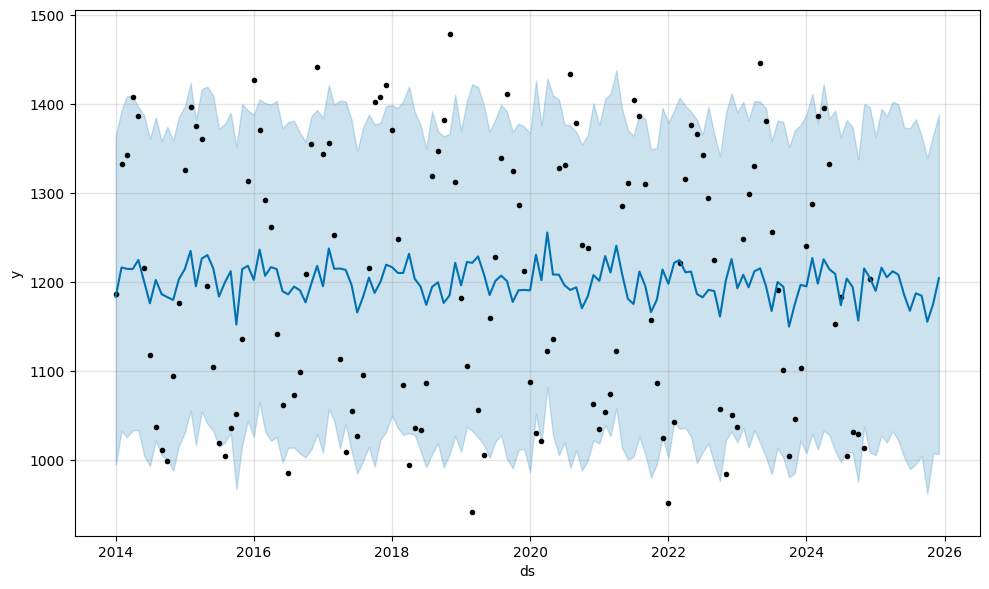

In [52]:
# Create future dataframe
future = m.make_future_dataframe(periods=12, freq='MS')
future = pd.merge(future, sales_data, on='ds', how='left')

# Interpolate missing regressor values
for col in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    future[col] = future[col].interpolate(method='linear', limit_direction='forward')

# Predict
forecast = m.predict(future)

# Plot
m.plot(forecast)
plt.show()

In [53]:
# Perform CV: 4-year initial, predict next 12 months, rolling every 6 months
df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon='365 days')

# Performance metrics
df_p = performance_metrics(df_cv)

# Display available columns
print("Available columns:", df_p.columns)

# Only use valid keys (no 'r2')
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']])

  0%|          | 0/13 [00:00<?, ?it/s]22:12:19 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:03,  3.33it/s]22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:02,  4.27it/s]22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:00<00:02,  4.56it/s]22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:01,  5.30it/s]22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:01,  5.28it/s]22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:01<00:01,  5.69it/s]22:12:21

Available columns: Index(['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage'], dtype='object')
     horizon         mae        rmse      mape  coverage
0    36 days  198.518099  215.042552  0.168166  0.333333
1    40 days  205.765741  223.565574  0.176895  0.333333
2    42 days  227.512805  246.540926  0.191395  0.266667
3    46 days  226.658006  245.476904  0.191201  0.266667
4    47 days  224.623708  243.972458  0.189348  0.333333
..       ...         ...         ...       ...       ...
132 356 days  199.677640  214.545488  0.171828  0.333333
133 359 days  187.821378  203.263735  0.158995  0.400000
134 362 days  176.015848  192.800548  0.151853  0.466667
135 364 days  180.720932  197.393290  0.154694  0.400000
136 365 days  173.097498  194.681580  0.149274  0.400000

[137 rows x 5 columns]


In [54]:
from sklearn.metrics import r2_score

r2 = r2_score(df_cv['y'], df_cv['yhat'])
print("R²:", r2)

R²: -0.8655901212314627


In [55]:
import pandas as pd
from prophet import Prophet

# Load the Excel file
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"
df_raw = pd.read_excel(file_path)

# Clean the data
if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)

df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

# Prophet Forecasting
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

# Forecast 12 future months
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Filter forecast for 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# Show forecasted values for 2025
forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
132,2025-01-01,1192.433375,1009.818973,1380.884189
133,2025-02-01,1219.575595,1045.649662,1399.241160
134,2025-03-01,1202.571416,1016.399186,1379.897899
135,2025-04-01,1219.812208,1049.585393,1404.385788
136,2025-05-01,1207.892911,1034.118122,1386.489908
137,2025-06-01,1191.164217,1011.887229,1372.105070
138,2025-07-01,1174.128095,987.993542,1356.422812
139,2025-08-01,1192.163849,1009.192491,1376.406206
140,2025-09-01,1191.209650,1002.445732,1370.816868
141,2025-10-01,1162.932686,985.995346,1359.038894


In [56]:
# --- Step 3: Bootstrapped Confidence Intervals for Prophet Forecast ---

# Merge actual and forecast to get residuals
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

# Generate 1000 bootstrapped forecasts for 2025
boot_samples = []
for _ in range(1000):
    sampled_residuals = np.random.choice(residuals, size=12, replace=True)
    simulated = forecast_2025['yhat'].values + sampled_residuals
    boot_samples.append(simulated)

boot_array = np.array(boot_samples)
forecast_2025['boot_lower'] = np.percentile(boot_array, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_array, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_array, 50, axis=0)

In [57]:
# --- Step 4: Reorder Point (ROP) Calculation with Prophet Forecast ---
k = 1.0  # risk parameter (higher = more conservative inventory)
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (
    forecast_2025['boot_upper'] - forecast_2025['boot_median']
)

In [58]:
# --- Step 5: ARIMA on Prophet Residuals ---
sales_data['forecast'] = m.predict(sales_data)['yhat']
sales_data['residuals'] = sales_data['y'] - sales_data['forecast']

# Fit ARIMA(1,0,1) on residuals
model_arima = ARIMA(sales_data['residuals'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()

# Forecast next 12 months residuals
arima_forecast = model_arima_fit.forecast(steps=12)

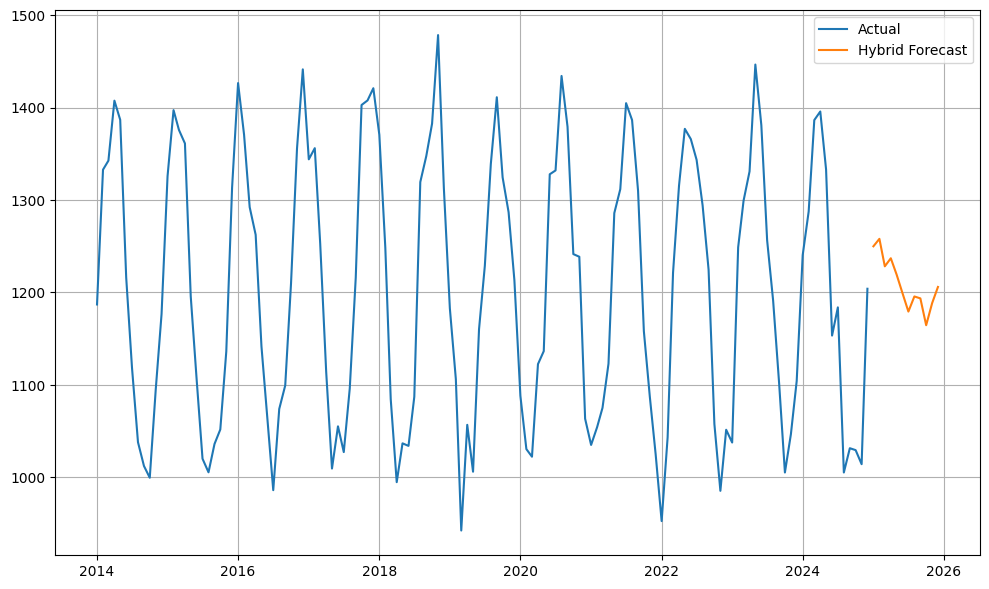

In [59]:
# --- Step 6: Hybrid Model = Prophet + ARIMA Residuals ---
arima_model = ARIMA(df_with_yhat['residual'], order=(1, 0, 1)).fit()
arima_pred = arima_model.forecast(steps=12)
forecast_2025['arima_correction'] = arima_pred.values

# Hybrid forecast: combine both
final_forecast = forecast.tail(12).copy()
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + arima_forecast.values

# Plot Hybrid Forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_data['ds'], sales_data['y'], label='Actual')
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# --- Step 7: AROPHET Final Forecast (Prophet + ARIMA) ---
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

In [61]:
# --- Step 8: Bootstrapped ROP from AROPHET ---
boot_arophet_samples = []
for _ in range(1000):
    boot_resid = np.random.choice(residuals, size=12, replace=True)
    sim = forecast_2025['arophet'].values + boot_resid
    boot_arophet_samples.append(sim)

boot_arophet_array = np.array(boot_arophet_samples)
forecast_2025['arophet_lower'] = np.percentile(boot_arophet_array, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_array, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_array, 50, axis=0)

forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (
    forecast_2025['arophet_upper'] - forecast_2025['arophet_median']
)


In [62]:
# --- Step 9: Forecast Accuracy Comparison ---
actual = df_clean['y'].values
prophet_pred = forecast.loc[forecast['ds'].isin(df_clean['ds']), 'yhat'].values
arima_correction_hist = arima_model.predict(start=0, end=len(df_clean) - 1)
arophet_pred = prophet_pred + arima_correction_hist

# Accuracy metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [mean_absolute_error(actual, prophet_pred),
            mean_absolute_error(actual, arophet_pred)],
    'RMSE': [np.sqrt(mean_squared_error(actual, prophet_pred)),
             np.sqrt(mean_squared_error(actual, arophet_pred))],
    'MAPE': [mape(actual, prophet_pred), mape(actual, arophet_pred)],
    'R2': [r2_score(actual, prophet_pred), r2_score(actual, arophet_pred)]
}

accuracy_df = pd.DataFrame(metrics)
# Show accuracy table and result table
print("Forecast Accuracy Comparison:")
print(accuracy_df)
print("\n2025 Forecast Table:")
print(forecast_2025[['ds', 'boot_median', 'prophet_rop', 'arophet_median', 'arophet_rop']])

Forecast Accuracy Comparison:
     Model         MAE        RMSE       MAPE        R2
0  Prophet  128.674095  144.113781  10.900000  0.013341
1  AROPHET   65.259247   82.262064   5.507847  0.678519

2025 Forecast Table:
            ds  boot_median  prophet_rop  arophet_median  arophet_rop
132 2025-01-01  1176.582903  1424.720344     1234.882535  1480.262388
133 2025-02-01  1222.175982  1451.862564     1263.132433  1481.193668
134 2025-03-01  1200.296336  1439.276751     1222.761381  1458.454751
135 2025-04-01  1235.804331  1452.099176     1233.638906  1468.200955
136 2025-05-01  1205.617831  1440.179879     1227.796629  1455.638324
137 2025-06-01  1205.607284  1427.869552     1190.111202  1431.072689
138 2025-07-01  1188.571161  1401.659819     1176.600017  1416.146093
139 2025-08-01  1188.757448  1428.869184     1198.517553  1423.567771
140 2025-09-01  1193.810038  1418.741375     1185.235296  1426.196783
141 2025-10-01  1177.375752  1395.219654     1162.646491  1401.626906
142 2025-1

In [63]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score
import plotly.express as px
import pandas as pd

# 1. Prophet cross-validation (adjust horizon if needed)
df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

# 2. Calculate R2 manually
prophet_cv_r2 = r2_score(df_cv['y'], df_cv['yhat'])

# 3. Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R2'],
    'Prophet_CV': [
        df_p['mae'].mean(),
        df_p['rmse'].mean(),
        df_p['mape'].mean(),
        prophet_cv_r2
    ],
    'AROPHET_Static': [
        accuracy_df.loc[1, 'MAE'],
        accuracy_df.loc[1, 'RMSE'],
        accuracy_df.loc[1, 'MAPE'],
        accuracy_df.loc[1, 'R2']
    ]
})

# 4. Melt for Plotly
plot_df = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# 5. Plot
fig = px.bar(
    plot_df,
    x='Metric',
    y='Score',
    color='Model',
    barmode='group',
    text_auto='.2f',
    title='Forecast Accuracy: Prophet CV vs AROPHET Static',
    labels={'Score': 'Error Metric'}
)

fig.update_layout(yaxis_title='Score (Lower is Better)', xaxis_title='Metric')
fig.show()

  0%|          | 0/13 [00:00<?, ?it/s]22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:03,  3.37it/s]22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:02,  4.29it/s]22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:00<00:02,  4.57it/s]22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:01,  5.29it/s]22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:01,  5.26it/s]22:12:23 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:01<00:01,  5.69it/s]22:12:23

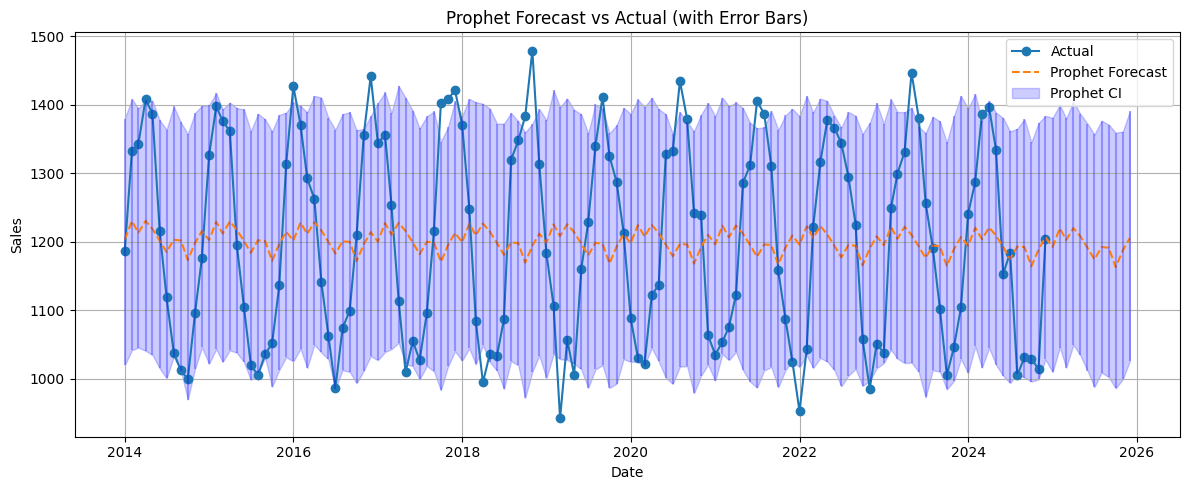

In [64]:
# --- Plot 1: Prophet Forecast with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Prophet CI')
plt.errorbar(forecast['ds'], forecast['yhat'],
             yerr=[forecast['yhat'] - forecast['yhat_lower'],
                   forecast['yhat_upper'] - forecast['yhat']],
             fmt='none', ecolor='blue', alpha=0.3)
plt.title('Prophet Forecast vs Actual (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

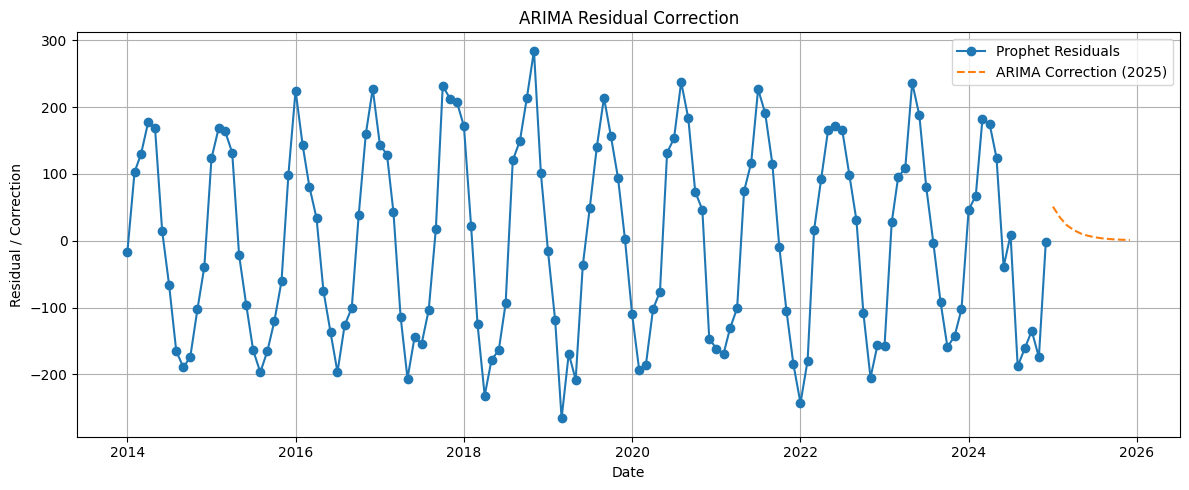

In [65]:
# --- Plot 2: ARIMA Residual Correction ---
plt.figure(figsize=(12, 5))
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], label='Prophet Residuals', marker='o')
plt.plot(pd.date_range(df_with_yhat['ds'].iloc[-1], periods=13, freq='MS')[1:],
         arima_pred, label='ARIMA Correction (2025)', linestyle='--')
plt.title('ARIMA Residual Correction')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

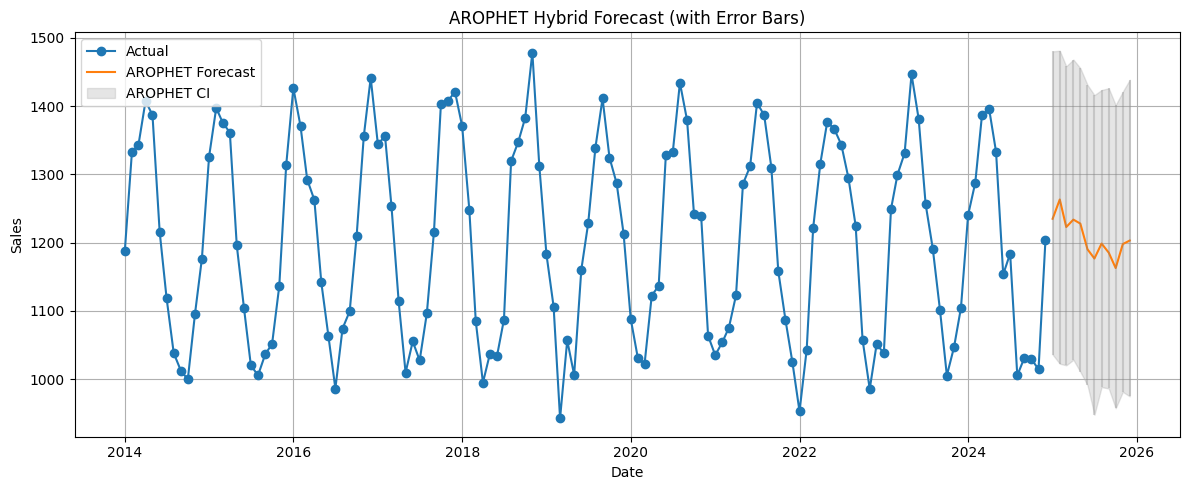

In [66]:
# --- Plot 3: AROPHET Hybrid Forecast with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                 color='gray', alpha=0.2, label='AROPHET CI')
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'],
             yerr=[forecast_2025['arophet_median'] - forecast_2025['arophet_lower'],
                   forecast_2025['arophet_upper'] - forecast_2025['arophet_median']],
             fmt='none', ecolor='gray', alpha=0.3)
plt.title('AROPHET Hybrid Forecast (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

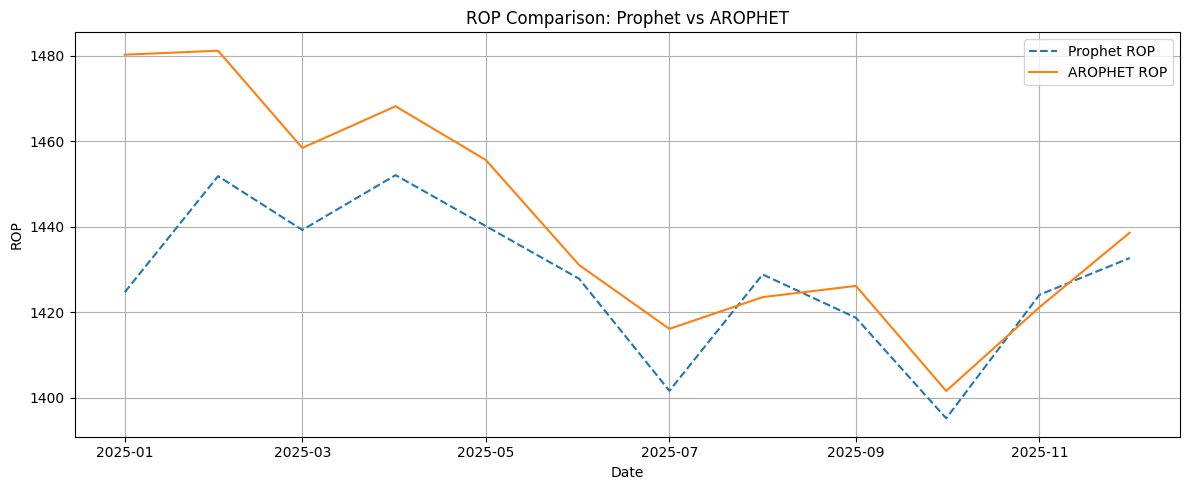

In [67]:
# --- Plot 4: Reorder Point (ROP) Comparison ---
plt.figure(figsize=(12, 5))
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

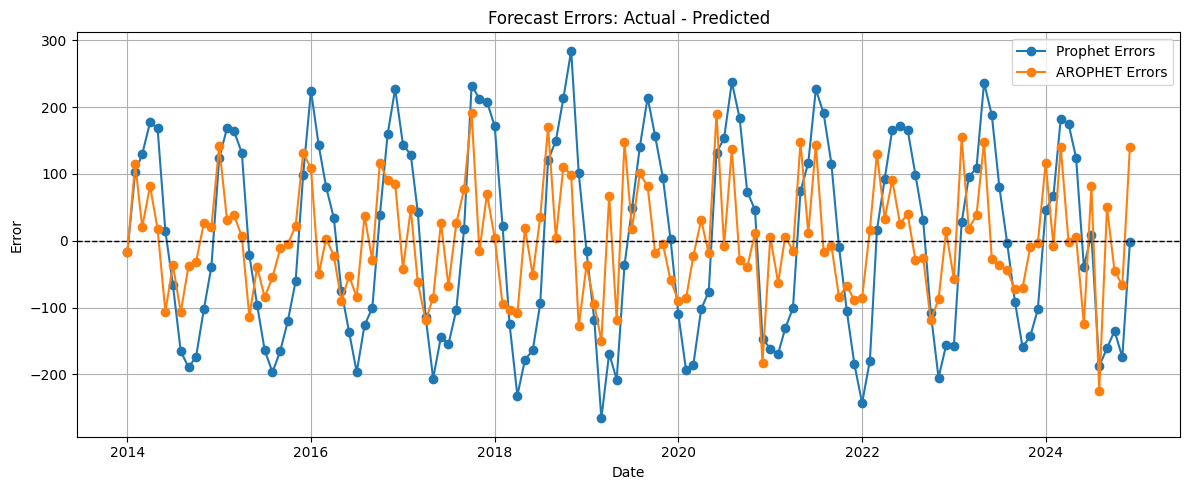

In [68]:
# --- Plot 5: Forecast Errors (Actual - Predicted) ---
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o')
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

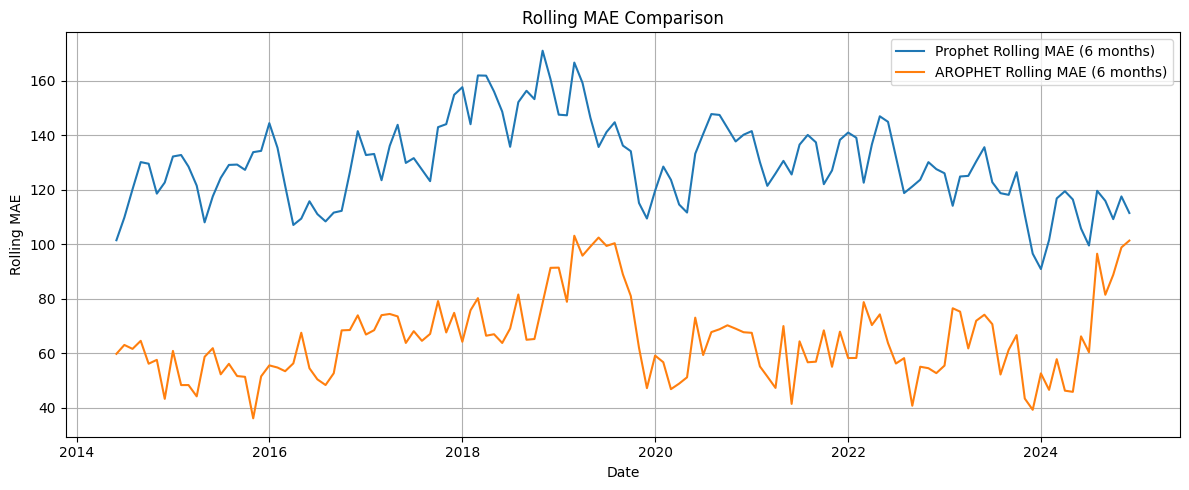

In [69]:
# --- Plot 6: Rolling MAE Comparison ---
window = 6
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], rolling_mae_prophet, label=f'Prophet Rolling MAE ({window} months)')
plt.plot(df_clean['ds'], rolling_mae_arophet, label=f'AROPHET Rolling MAE ({window} months)')
plt.title('Rolling MAE Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
import plotly.express as px
import plotly.graph_objects as go

# Interactive Plot - Actual vs Forecasted Sales
fig = px.line(df_clean, x='ds', y='y', title='Actual vs Forecasted Sales')

# Add Prophet forecast
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prophet Forecast', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(dash='dot', color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(dash='dot', color='lightgrey'), fill='tonexty', fillcolor='rgba(200,200,200,0.2)', showlegend=False))

fig.write_html("actual_vs_forecast.html")  # Saves the interactive HTML

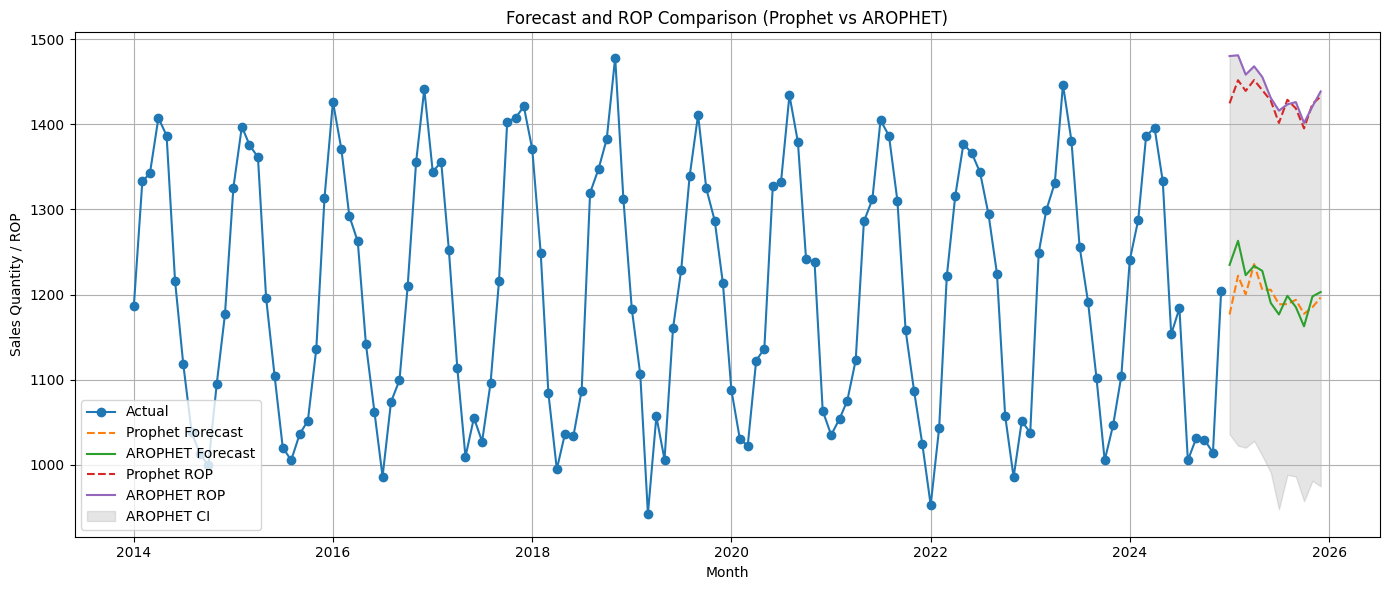

In [71]:
# --- Final Summary Plot: Forecast + ROP Combined ---
plt.figure(figsize=(14, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                 color='gray', alpha=0.2, label='AROPHET CI')
plt.title("Forecast and ROP Comparison (Prophet vs AROPHET)")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
